# Exercise 2 — Finetuning a Pretrained Model for Binary Text Classification

This notebook follows the required flow:

1. Install the necessary Hugging Face libraries (`transformers`, `datasets`, `evaluate`)
2. Load a dataset for binary text classification (from `train_clean.csv`)
3. Load a pretrained model and tokenizer
4. Preprocess/tokenize the dataset
5. Define training arguments
6. Create a `Trainer` and finetune the model
7. Evaluate the finetuned model

**Dataset files**
- Train (supervised): `data/processed/train_clean.csv` with columns `text,label` (label ∈ {0,1})
- Test (inference): `data/processed/test_clean.csv` with columns `id,text` (and possibly `keyword,location`)


## 1) Install libraries (run once)

In [ ]:
# If you already installed these in your environment, you can skip this cell.
# For Apple Silicon / conda envs, you may prefer installing via conda-forge for torch.
%pip -q install -U transformers datasets evaluate accelerate scikit-learn


## 2) Imports, paths, and reproducibility

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

TRAIN_CSV = "../data/processed/train_clean.csv"
TEST_CSV  = "../data/processed/test_clean.csv"


print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("train exists:", os.path.exists(TRAIN_CSV))
print("test exists:", os.path.exists(TEST_CSV))


torch: 2.2.2
cuda available: False
train exists: True
test exists: True


## 3) Load dataset + quick validation

In [4]:
# Load train_clean.csv
train_df = pd.read_csv(TRAIN_CSV)

required = {"text", "label"}
missing = sorted(required - set(train_df.columns))
if missing:
    raise ValueError(f"Missing required columns in train: {missing}. Available: {train_df.columns.tolist()}")

# Basic label validity
train_df = train_df.dropna(subset=["text", "label"]).copy()
train_df["text"] = train_df["text"].astype(str).str.strip()
train_df = train_df[train_df["text"] != ""]
train_df["label"] = train_df["label"].astype(int)

labels = sorted(train_df["label"].unique().tolist())
print("Shape:", train_df.shape)
print("Label dtype:", train_df["label"].dtype, "| unique labels:", labels)
if labels != [0, 1]:
    raise ValueError(f"Expected binary labels [0,1], got {labels}")

train_df.head(5)


Shape: (7485, 2)
Label dtype: int64 | unique labels: [0, 1]


,text,label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## 4) EDA essentials (label balance + text length)

Label counts:
 label
0    4297
1    3188
Name: count, dtype: int64

Label ratios (%):
 label
0    57.41
1    42.59
Name: proportion, dtype: float64

Majority baseline accuracy: 0.5741


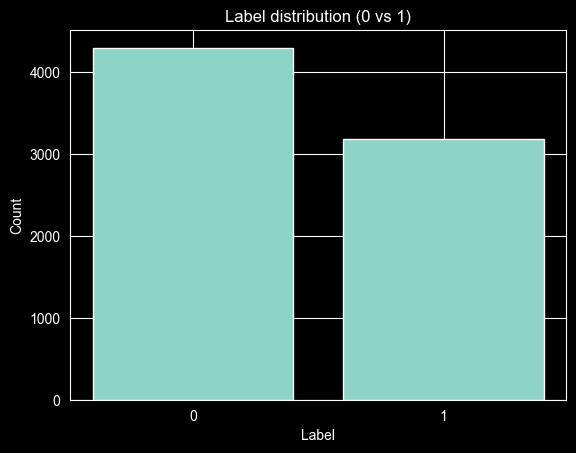

,len_words,len_chars
count,7485.000000,7485.000000
mean,14.873480,100.879893
std,5.733471,33.827116
min,1.000000,7.000000
50%,15.000000,107.000000
90%,22.000000,138.000000
95%,24.000000,140.000000
99%,27.000000,143.000000
max,31.000000,157.000000


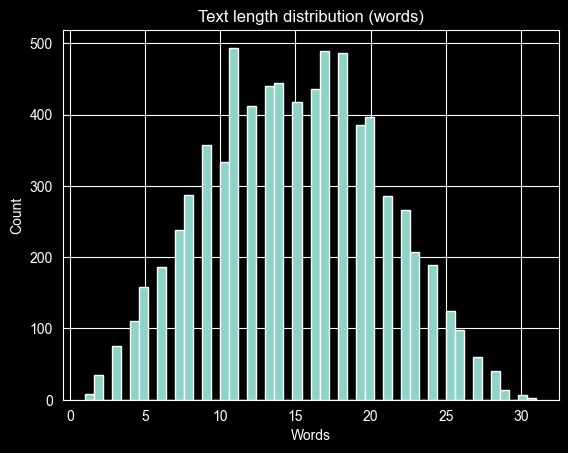

In [5]:
counts = train_df["label"].value_counts().sort_index()
ratios = train_df["label"].value_counts(normalize=True).sort_index()

# label = 0 → Not Disaster (tweet bình thường, không phải thảm hoạ)
# label = 1 → Disaster (tweet nói về thảm hoạ thật)
print("Label counts:\n", counts)
print("\nLabel ratios (%):\n", (ratios * 100).round(2))
print("\nMajority baseline accuracy:", round(ratios.max(), 4))

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Label distribution (0 vs 1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

train_df["len_words"] = train_df["text"].str.split().apply(len)
train_df["len_chars"] = train_df["text"].str.len()

display(train_df[["len_words","len_chars"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(train_df["len_words"], bins=50)
plt.title("Text length distribution (words)")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()


## 5) Load pretrained model and tokenizer

In [6]:
# A solid baseline for English tweets
MODEL_CHECKPOINT = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)

print("Loaded:", MODEL_CHECKPOINT)
print("Tokenizer vocab size:", tokenizer.vocab_size)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded: distilbert-base-uncased
Tokenizer vocab size: 30522


## 6) Token length EDA (helps choose max_length)

count    2000.000000
mean       33.396000
std        12.194201
min         3.000000
50%        34.000000
90%        48.100000
95%        53.000000
99%        61.000000
max        73.000000
Name: text, dtype: float64


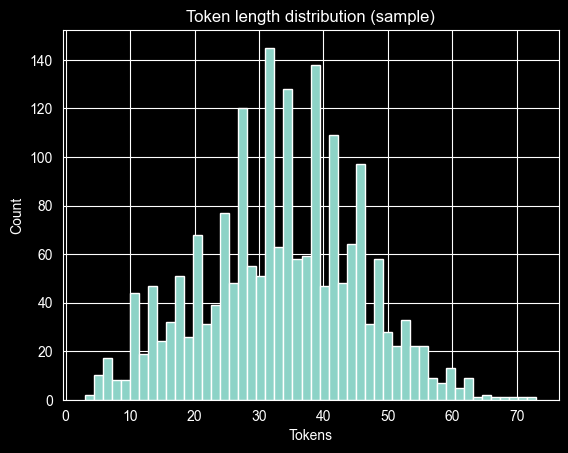

Default MAX_LENGTH = 128 (adjust if needed based on percentiles above)


In [7]:
def token_len(text: str) -> int:
    return len(tokenizer(text, truncation=False)["input_ids"])

# sample for speed
sample = train_df["text"].sample(min(2000, len(train_df)), random_state=SEED)
tok_lens = sample.apply(token_len)

print(tok_lens.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

plt.figure()
plt.hist(tok_lens, bins=50)
plt.title("Token length distribution (sample)")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

# Suggested default max_length
MAX_LENGTH = 128
print("Default MAX_LENGTH =", MAX_LENGTH, "(adjust if needed based on percentiles above)")


## 7) Build Hugging Face `datasets` + train/validation split

In [8]:
# Use datasets for efficient mapping/tokenization
# We use the cleaned pandas frame (train_df) to avoid surprises.
from datasets import Dataset

ds = Dataset.from_pandas(train_df[["text", "label"]], preserve_index=False)

# Convert label -> ClassLabel (quan trọng để stratify)
ds = ds.class_encode_column("label")
ds = ds.train_test_split(test_size=0.2, seed=SEED, stratify_by_column="label")
train_ds, val_ds = ds["train"], ds["test"]

print(train_ds)
print(val_ds)
from collections import Counter

print("train label counts:", Counter(train_ds["label"]))
print("val label counts:", Counter(val_ds["label"]))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Stringifying the column:   0%|          | 0/7485 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/7485 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 5988
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1497
})
train label counts: Counter({0: 3438, 1: 2550})
val label counts: Counter({0: 859, 1: 638})


## 8) Tokenize / preprocess

In [9]:
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH,
    )

tokenized_train = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
tokenized_val   = val_ds.map(tokenize_batch, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_train


Map:   0%|          | 0/5988 [00:00<?, ? examples/s]

Map:   0%|          | 0/1497 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 5988
})

## 9) Metrics (accuracy + F1)

In [10]:
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1  = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
    return {"accuracy": acc, "f1": f1}


## 10) Training arguments

In [11]:
use_fp16 = torch.cuda.is_available()

kwargs = dict(
    output_dir=OUT_DIR,
    seed=SEED,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=50,
    report_to="none",
    fp16=use_fp16,
)

try:
    training_args = TrainingArguments(**kwargs, eval_strategy="epoch")
except TypeError:
    training_args = TrainingArguments(**kwargs, evaluation_strategy="epoch")

training_args


NameError: name 'OUT_DIR' is not defined

## 11) Trainer + finetuning

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
train_result


## 12) Evaluate the finetuned model

In [ ]:
metrics = trainer.evaluate()
metrics


## 13) Predict on test_clean.csv + create submission.csv (optional, for Kaggle)

In [ ]:
from datasets import Dataset  # thêm import này nếu chưa có

test_df = pd.read_csv(TEST_CSV)

# Minimal requirements: id + text
required = {"id", "text"}
missing = sorted(required - set(test_df.columns))
if missing:
    raise ValueError(f"test_clean.csv missing columns: {missing}. Available: {test_df.columns.tolist()}")

# Hygiene for test
test_df = test_df.dropna(subset=["text"]).copy()
test_df["text"] = test_df["text"].astype(str).str.strip()
test_df = test_df[test_df["text"] != ""].reset_index(drop=True)

# Create HF Dataset directly (no temp CSV needed)
test_ds = Dataset.from_pandas(test_df[["id", "text"]], preserve_index=False)

def tokenize_test(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LENGTH)

tokenized_test = test_ds.map(tokenize_test, batched=True, remove_columns=["text"])

pred = trainer.predict(tokenized_test)
preds = np.argmax(pred.predictions, axis=-1).astype(int)

submission = pd.DataFrame({"id": test_df["id"].astype(int), "target": preds})
assert len(submission) == len(test_df)

out_sub = "../data/processed/sample_submission.csv"
os.makedirs(os.path.dirname(out_sub), exist_ok=True)
submission.to_csv(out_sub, index=False)

print("Saved submission:", out_sub)
submission.head(10)


## 14) Notes for your presentation

- **Binary labels {0,1}**: required because the model head is configured with `num_labels=2`, and the loss (cross-entropy) expects integer class indices.
- **Validation split**: Kaggle test has no labels, so evaluation must be done on a held-out validation set from train.
- **max_length**: chosen based on token-length distribution to balance speed vs. truncation.
- **Metrics**: accuracy + F1. F1 is helpful when classes are not perfectly balanced.
